## 以狀態值函數大者為行動依據

In [163]:
# 載入相關套件
import numpy as np
import random

In [164]:
# 參數設定
NODE_COUNT = 15      # 節點數
NORMAL_REWARD = -0.02 # 每走一步扣分 0.02

In [165]:
# 環境類別
class Environment():
    # 初始化
    def __init__(self):
        # 儲存狀態值函數，索引值[0]:不用，從1開始
        self.state_value = np.full((NODE_COUNT+1), 0.0)

        # 更新次數，索引值[0]:不用，從1開始
        self.state_value_count = np.full((NODE_COUNT+1), 0)
        
    # 初始化
    def reset(self):
        self.poistion = int((1+NODE_COUNT) / 2)  # 玩家一開始站中間位置
        self.trajectory=[self.poistion] # 行動軌跡

    def get_states(self):
        # 狀態空間(State Space)
        return [i for i in range(1, NODE_COUNT+1)]

    def get_actions(self):        
        return [-1, 1] # 行動空間(Action Space)

    def is_done(self): # 判斷比賽回合是否結束
        # 是否走到左右端點
        return self.poistion == 1 or self.poistion == NODE_COUNT
    
    # 步驟
    def step(self, action):
        # 是否回合已結束
        if self.is_done():
            raise Exception("Game over")
            
        self.poistion += action
        self.trajectory.append(self.poistion)        
        if self.poistion == 1:
            reward = -1
        elif self.poistion == NODE_COUNT:
            reward = 1
        else:    
            reward = NORMAL_REWARD

        return self.poistion, reward

    def update_state_value(self, final_value):
        # 倒推，更新狀態值函數
        # 缺點：未考慮節點被走過兩次或以上，分數會被重複扣分
        for i in range(len(self.trajectory)-1, -1, -1):
            final_value += NORMAL_REWARD
            self.state_value[self.trajectory[i]] += final_value
            self.state_value_count[self.trajectory[i]] += 1
                
    # 取得狀態值函數期望值
    def get_observation(self):
        mean1 = np.full((NODE_COUNT+1), 0.0)
        for i in range(1, NODE_COUNT+1):
            if self.state_value_count[i] == 0: 
                mean1[i] = 0
            else:
                mean1[i] = self.state_value[i] / self.state_value_count[i]
        return mean1

In [166]:
# 代理人類別
class Agent():
    # 初始化
    def __init__(self):
        pass
        
    def action(self, env):
        # 取得狀態值函數期望值
        state_value = env.get_observation()
        
        # 以左/右節點狀態值函數大者為行動依據，如果兩個狀態值一樣大，隨機選擇一個
        if state_value[env.poistion-1] > state_value[env.poistion+1]: 
            next_action = -1
        if state_value[env.poistion-1] < state_value[env.poistion+1]: 
            next_action = 1
        else:  
            next_action = random.choice(env.get_actions()) 
            
        # 如果偵測到循環，採反向行動      
#         if len(env.trajectory)>=3 and \
#             env.poistion + next_action == env.trajectory[-2] and \
#             env.trajectory[-1] == env.trajectory[-3]:
#             # print('loop:', env.trajectory[-3:], env.poistion + next_action)
#             next_action = -next_action
        return next_action           

In [228]:
# 建立實驗，含環境、代理人物件
env = Environment()
agent = Agent()

# 進行實驗
total_reward_list = []
for i in range(10):
    env.reset()  # 重置
    total_reward=0  # 累計報酬
    action_count = 0
    while not env.is_done():
        # 採取行動
        action = agent.action(env)
        action_count+=1
        
        # 更新下一步
        state, reward = env.step(action)
        #print(state, reward)
        # 計算累計報酬
        total_reward += reward
        
        # 避免一直循環，跑不完
        if action_count > 100:
            env.poistion = int((1+NODE_COUNT) / 2)
            break
    
    print(f'trajectory {i}: {env.trajectory}')
    # 未達終點不更新值函數，以免過度降低循環節點的值函數
    if action_count <= 100:
        env.update_state_value(total_reward)
    # print(f"state value: {list(np.around(env.get_observation()[1:] ,2))}")
    total_reward_list.append(round(total_reward, 2))
    
# 顯示累計報酬
print(f"累計報酬: {total_reward_list}")

trajectory 0: [8, 9, 8, 7, 6, 7, 6, 5, 6, 7, 6, 7, 6, 7, 6, 7, 8, 9, 8, 7, 8, 9, 8, 9, 8, 9, 10, 9, 8, 9, 10, 11, 10, 11, 12, 11, 10, 11, 10, 11, 10, 11, 10, 11, 12, 13, 12, 13, 14, 15]
trajectory 1: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 2: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 3: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 4: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 5: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 6: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 7: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 8: [8, 9, 10, 11, 12, 13, 14, 15]
trajectory 9: [8, 9, 10, 11, 12, 13, 14, 15]
累計報酬: [-47, -5, -5, -5, -5, -5, -5, -5, -5, -5]


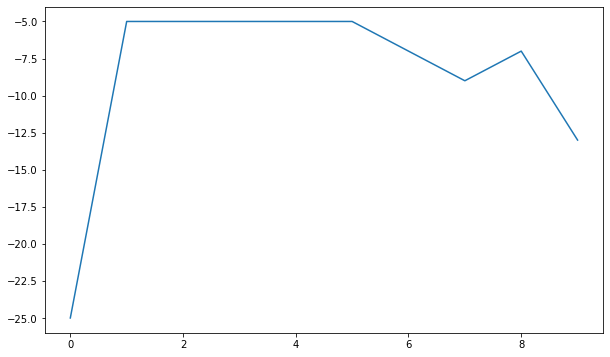

In [168]:
# 繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(total_reward_list)

In [169]:
env.get_observation()[1:]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , -52.        , -23.        ,
       -23.27272727, -25.        , -21.86666667, -16.33333333,
       -11.6       , -10.6       ,  -9.6       ])